20171103
Time evolution of matrix product mixed state

In [1]:
import numpy as np
import time
import scipy
from tqdm import tqdm
from scipy import linalg
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy import io

In [23]:
sx=np.array([[0.,1.],[1.,0.]])
sy=np.array([[0.,-1j],[1j,0.]])
sz=np.array([[1.,0.],[0.,-1.]])

d=2 # Dimension. For spin 1/2 the dimention = 2
J=1. # XX interaction coefficient
gz=0. # Z field strength
gx=0. # X field strength
delta =0.01 # Time step
interaction='Dipolar' # Heisenberg: J(XX+YY+ZZ); Ising: JXX; Dipolar J(XX-(YY+ZZ)/2)
beta=0.001 # inverse temperature
pol=sx # initial polarization
chi=100 # Maximum number of singular values
thr=1e-8; # discarding singular values smaller than thr*largest singular value
#T=3;

if interaction=='Heisenberg':
    h_int=J*np.kron(sx,sx)+J*np.kron(sy,sy)+J*np.kron(sz,sz)
elif interaction=='Ising':
    h_int=J*np.kron(sx,sx)
elif interaction=='Dipolar':
    h_int=J*(np.kron(sx,sx)-np.kron(sz,sz)/2-np.kron(sy,sy)/2)
else:
    raise NameError('Invalid interaction')
h_single=gz*sz+gx*sx
U_int=linalg.expm(1j*h_int*delta/2).reshape(d,d,d,d) # U(si,s(i+1),si',s(i+1)')
U_z=linalg.expm(1j*h_single*delta).reshape(d,d) # U(si,si')
h_local=h_int+np.kron(h_single,np.eye(2))#/2+np.kron(np.eye(2),h_single)/2
U_local=linalg.expm(1j*h_local*delta/2).reshape(d,d,d,d)

Mz=np.kron(sz,np.eye(d))+np.kron(np.eye(d),sz)
Mz=Mz.reshape(d,d,d,d)
Mx=np.kron(sx,np.eye(d))+np.kron(np.eye(d),sx)
Mx=Mx.reshape(d,d,d,d)

#rho0i=np.transpose(np.array([[np.eye(2),np.zeros((2,2))],[sx,np.eye(2)]]),(2,3,0,1)) # rho0i(si,si',ai,bi)
rho0i=linalg.expm(-beta/2*pol).reshape(d,d,1,1)/np.sqrt(np.exp(beta)+np.exp(-beta)) # rho0i(si,si',ai,bi)
rho0=[rho0i,rho0i]

band0i=np.ones(1)
band0=[band0i,band0i]

def exp1(rho,band,U):
    #1e-6 should be good enough
    E=[]
    for A in range(0,2):
        B=1-A
        theta=np.tensordot(np.diag(band[B]),rho[A],axes=(0,2)) # theta(a0,s0,s0',b0)
        theta=np.tensordot(theta,np.diag(band[A]),axes=(3,0)) # theta(a0,s0,s0',b0)
        theta=np.tensordot(theta,np.conj(theta),axes=([0,2,3],[0,2,3])) # theta(s0,s0*)
        E.append(np.tensordot(theta,U,axes=([0,1],[0,1])))
    return np.mean(E)

def evo1(rho,U):
    for A in range(0,2):
        theta=np.tensordot(U,rho[A],axes=([1,0])) # theta(s,s',a,b,)
        rho[A]=theta

def evo2(rho,band,U,chi,direction):
    if direction=='f':
        rangep=range(0,2)
    elif direction=='b':
        rangep=range(1,-1,-1)
    else:
        raise NameError('Invalid direction')
    for A in rangep:
        B=1-A
        #print(A,B)
        dB=(rho[A].shape[2])
        theta=np.tensordot(np.diag(band[B]),rho[A],axes=(0,2)) # theta(a0,s0,s0',b0)
        theta=np.transpose(theta,(1,2,0,3)) # theta(s0,s0',a0,b0)
        theta=np.tensordot(theta,np.diag(band[A]),axes=(3,0)) # theta(s0,s0',a0,b0)
        theta=np.tensordot(theta,rho[B],axes=(3,2)) # theta(s0,s0',a0,s1,s1',b1)
        theta=np.tensordot(theta,np.diag(band[B]),axes=(5,0))# theta(s0,s0',a0,s1,s1',b1)

        # Apply U
        theta=np.tensordot(theta,U,axes=([0,3],[2,3])) # theta(s0',a0,s1',b1,s0,s1)
        theta=np.transpose(theta,(4,0,1,5,2,3)) # theta(s0,s0',a0,s1,s1',b1)
        sh=theta.shape
        theta=theta.reshape(sh[0]*sh[1]*sh[2],sh[3]*sh[4]*sh[5]) # theta(s0*s0'*a0,s1*s1'*b1)
        [L,S,R]=scipy.linalg.svd(theta, lapack_driver='gesvd')
        ent=S.shape[0];
        #print(S)
        for i in range(1,S.shape[0]):
            if S[i]<thr*S[0]:
                ent=i
                break
        if ent<chi:
            D=S[0:ent]
        else:
            ent=chi
            D=S[0:ent]
        sq=np.sqrt(sum(D**2))
        band[A]=D/sq
        L=L[:,0:ent]
        R=R[0:ent,:]
        
        L=L.reshape(d,d,dB,ent) # L(s0,s0',a0,b0)
        L=np.tensordot(L,np.diag(band[B]**-1),axes=(2,0)) # L(s0,s0',b0,a0)
        rho[A]=np.transpose(L,(0,1,3,2))
        R=R.reshape(ent,d,d,dB) # R(a1,s1,s1',b1)
        R=np.tensordot(R,np.diag(band[B]**-1),axes=(3,0)) # R(a1,s1,s1',b1)
        R=np.transpose(R,(1,2,0,3)) # R(s1,s1',a1,b1)
#         test=np.tensordot(L,np.diag(lda[A]),axes=([3,0])) # test(s0,s0',a0,b0)
#         test=np.tensordot(test,R,axes=([3,2])) # test(s0,s0',a0,s1,s1',b1)
        rho[B]=R
#         print('A=',rho[A])
#         print('B=',rho[B])
#         print('bandA=',band[A])
#         print('bandB=',band[B])
# def evo(rho,band,U_int,U_single,Nsteps,chi):
#     for p in range(0,Nsteps):
#         evo2(rho,band,U_local,chi,'f')
#         evo2(rho,band,U_local,chi,'f')
def evo(rho,band,U_int,U_single,Nsteps,chi):
    for p in range(0,Nsteps):
        evo2(rho,band,U_int,chi,'f')
        evo1(rho,U_single)
        evo2(rho,band,U_int,chi,'b')
        
def overlap(rho1,band1,rho2,band2):
    E=[]
    for A in range(0,2):
        B=1-A
        theta=np.tensordot(rho1[A],rho2[A],axes=([0,1],[0,1])) # theta(1a,1b,2a,2b)
        theta=np.tensordot(np.diag(band1[A]),theta,axes=(0,1)) # theta(1b,1a,2a,2b)
        theta=np.tensordot(theta,np.diag(band2[A]),axes=(3,0)) # theta(1b,1a,2a,2b)
        theta=np.transpose(theta,(1,0,2,3)) # theta(1a,1b,2a,2b)
        sh=theta.shape
        theta=theta.reshape(sh[0]*sh[1],sh[2]*sh[3])
        w=np.linalg.eigvals(theta)
        wp=np.real(w)
        Meig=wp.argmax()
        E.append(wp[Meig])
    return np.mean(E)-1/2

Time evolution under constant Hamiltonian

In [8]:
start=time.time()
T=3 # evolution time to be simulated
Nsteps=1 # number of evolution steps between two measurements
Npts=int(T/delta/Nsteps+1) # number of points to evalue the observables
tlist=np.arange(0,Npts*delta*Nsteps,delta*Nsteps)

MzExp=np.zeros(Npts)
MxExp=np.zeros(Npts)

rho=list(rho0)
band=list(band0)
MzExp[0]=np.real(exp1(rho,band,sz))
MxExp[0]=np.real(exp1(rho,band,sx))

for p in tqdm(range(1,Npts)):
    evo(rho,band,U_int,U_z,Nsteps,chi)
    MzExp[p]=np.real(exp1(rho,band,sz))
    MxExp[p]=np.real(exp1(rho,band,sx))
    #print(tlist[p])
end=time.time()
print(end-start)

100%|██████████| 60/60 [00:27<00:00,  2.20it/s]

27.215231895446777


Time crystal

In [30]:
tau=0.5 # Floquet period
Npts=20 # number of Floquet periods
epsilon=0.15 # perturbation
tlist=np.arange(0,Npts*tau,tau)
Nsteps=round(tau/delta)

MzExp=np.zeros(Npts)
MxExp=np.zeros(Npts)

rho=list(rho0)
band=list(band0)
MzExp[0]=np.real(exp1(rho,band,sz))
MxExp[0]=np.real(exp1(rho,band,sx))

Up=linalg.expm(1j*sz*(1+epsilon)*np.pi/2)

for p in tqdm(range(1,Npts)):
    evo(rho,band,U_int,U_z,Nsteps,chi)
    evo1(rho,Up)
    MzExp[p]=np.real(exp1(rho,band,sz))
    MxExp[p]=np.real(exp1(rho,band,sx))
    #print(tlist[p])

100%|██████████| 19/19 [18:37<00:00, 58.80s/it]


In [15]:
Ncont=10 # number of Floquet periods
tlist=np.arange(0,(Npts+Ncont)*tau,tau)
for p in tqdm(range(1,Npts)):
    evo(rho,band,U_int,U_z,Nsteps,chi)
    evo1(rho,Up)
    MzExp=np.append(MzExp,np.real(exp1(rho,band,sz)))
    MxExp=np.append(MxExp,np.real(exp1(rho,band,sx)))

100%|██████████| 9/9 [04:44<00:00, 31.61s/it]


In [28]:
MxExp/MxExp[0]

array([ 1.        ,  0.58778525,  0.46760351,  0.38917735,  0.26088615,
        0.28722245,  0.22751341,  0.19774676,  0.17145913,  0.15357573,
        0.12341472,  0.10210477,  0.12184359,  0.1274406 ,  0.08787253,
        0.05950176, -0.11242956, -0.13315429, -0.1906624 , -0.29624306])

<IPython.core.display.Javascript object>


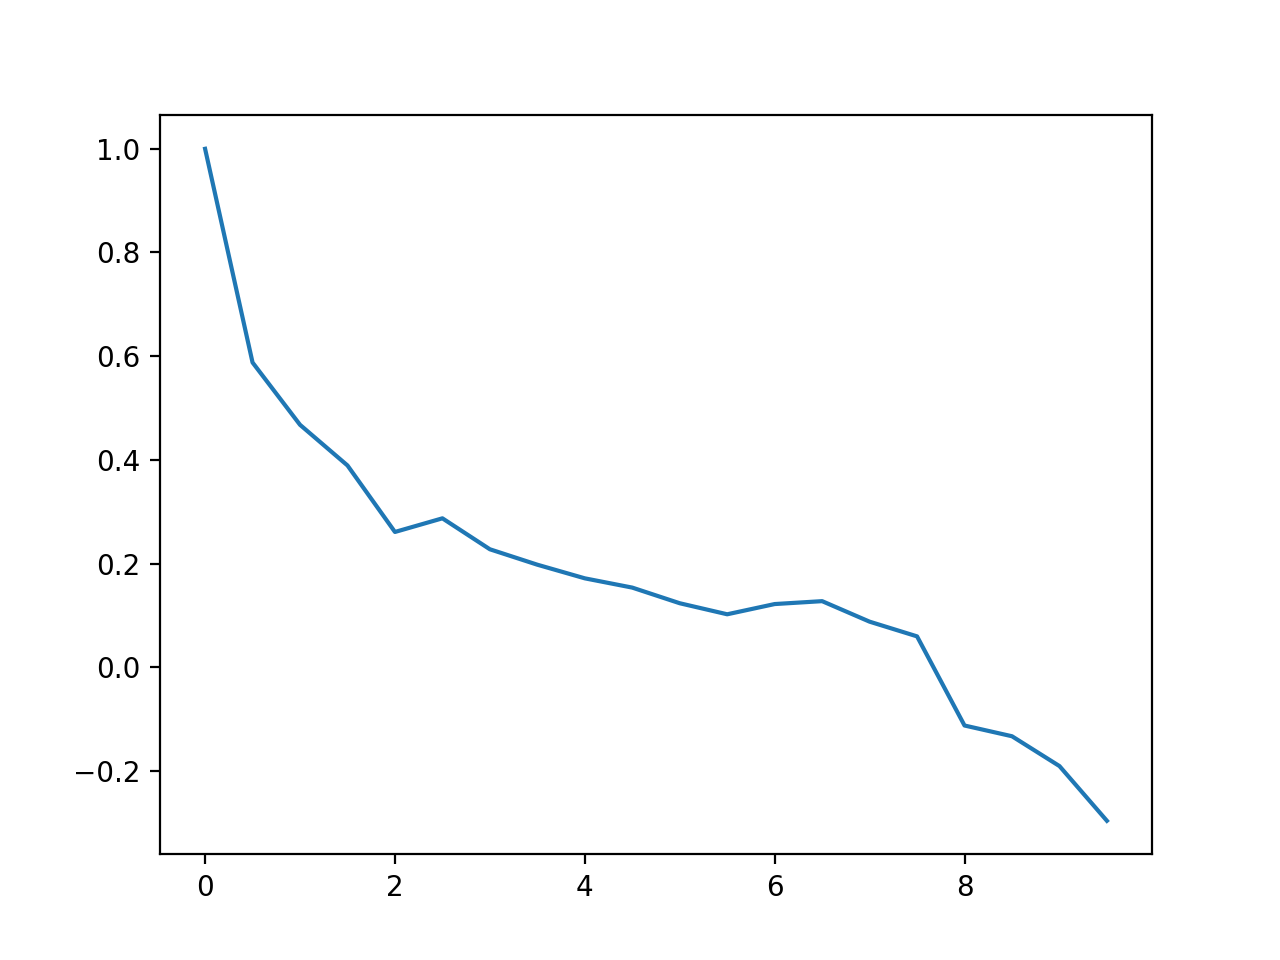

In [29]:
plt.plot(tlist,MxExp/MxExp[0])
plt.show()

OTOC

In [3]:
start=time.time()
T=3
Npts=round(T/delta) # number of points to evalue the observables
q_max=9
phi_list=np.arange(0,2*q_max,1)*2*np.pi/(2*q_max)
s_list=[]

rho=list(rho0)
band=list(band0)
V0=sz # encoding axis

evo(rho,band,U_int,U_z,Npts,chi)
for phi in phi_list:
    U_phi=linalg.expm(1j*phi/2*V0)
    rhot=list(rho)
    bandt=list(band)
    evo1(rhot,U_phi)
    evo(rhot,bandt,np.conj(U_int),np.conj(U_z),Npts,chi)
    s_list=np.append(s_list,np.real(exp1(rhot,bandt,sx)))
    print(phi)
q_list=np.fft.rfft(s_list)/len(s_list)
otoc=sum(np.multiply(np.power(np.arange(0,len(q_list)),2),abs(q_list)))
end=time.time()
print(end-start)

0.0
0.349065850399
0.698131700798
1.0471975512
1.3962634016
1.74532925199
2.09439510239
2.44346095279
2.79252680319
3.14159265359
3.49065850399
3.83972435439
4.18879020479
4.53785605519
4.88692190558
5.23598775598
5.58505360638
5.93411945678
19671.330805540085


In [9]:
start=time.time()
q_max=13
phi_list=np.arange(0,2*q_max,1)*2*np.pi/(2*q_max)
s_list=[]
for phi in phi_list:
    U_phi=linalg.expm(1j*phi/2*V0)
    rhot=list(rho)
    bandt=list(band)
    evo1(rhot,U_phi)
    evo(rhot,bandt,np.conj(U_int),np.conj(U_z),Npts,chi)
    s_list=np.append(s_list,np.real(exp1(rhot,bandt,sx)))
    print(phi)
q_list=np.fft.rfft(s_list)/len(s_list)
otoc=sum(np.multiply(np.power(np.arange(0,len(q_list)),2),np.real(q_list)))
end=time.time()
print(end-start)

0.0
0.241660973353
0.483321946706
0.724982920059
0.966643893412
1.20830486677
1.44996584012
1.69162681347
1.93328778682
2.17494876018
2.41660973353
2.65827070688
2.89993168024
3.14159265359
3.38325362694
3.6249146003
3.86657557365
4.108236547
4.34989752036
4.59155849371
4.83321946706
5.07488044041
5.31654141377
5.55820238712
5.79986336047
6.04152433383
28183.17950129509


In [92]:
start=time.time()
T=0
Npts=round(T/delta) # number of points to evalue the observables
q_max=7
phi_list=np.arange(0,2*q_max,1)*2*np.pi/(2*q_max)
s_list=[]

rho=list(rho0)
band=list(band0)
V0=sz # encoding axis

evo(rho,band,U_int,U_z,Npts,chi)
for phi in phi_list:
    U_phi=linalg.expm(1j*phi/2*V0)
    rhot=list(rho)
    bandt=list(band)
    evo1(rhot,U_phi)
    s_list=np.append(s_list,overlap(rho,band,rhot,bandt))
    print(phi)
q_list=np.fft.rfft(s_list)#/len(s_list)
otoc=sum(np.multiply(np.power(np.arange(0,len(q_list)),2),abs(q_list)))

0.0
0.448798950513
0.897597901026
1.34639685154
1.79519580205
2.24399475256
2.69279370308
3.14159265359
3.5903916041
4.03919055462
4.48798950513
4.93678845564
5.38558740615
5.83438635667


In [192]:
exp1(rho0,band0,sx)-s_list[0]

1.8779223432373315e-09

In [14]:
q_list=np.fft.rfft(s_list)/len(s_list)
otoc=sum(np.multiply(np.power(np.arange(0,len(q_list)),2),abs(q_list)))

In [210]:
s_list

array([-0.001     , -0.00078459, -0.00041526, -0.00012554,  0.00012404,
        0.00041487,  0.00078457,  0.001     ,  0.00078459,  0.00041526,
        0.00012554, -0.00012404, -0.00041487, -0.00078457])

In [4]:
q_list

array([ -2.15093664e-17 +0.00000000e+00j,
        -3.99535496e-04 -2.94113357e-06j,
        -2.86462308e-16 +4.27668441e-16j,
        -8.19809732e-05 +2.16477576e-06j,
        -4.11981767e-17 +9.85859765e-17j,
        -1.59125750e-05 -1.10337761e-06j,
        -8.94346325e-17 -9.20658933e-17j,
        -1.67465665e-06 +8.65187788e-07j,
         4.27970738e-16 +5.63563019e-17j,  -1.86879162e-06 +0.00000000e+00j])

In [12]:
q_list

array([  5.01835486e-16 +0.00000000e+00j,
        -3.99977847e-04 -3.63276982e-06j,
         3.04062968e-16 +8.69620710e-17j,
        -8.10482012e-05 +1.90039355e-06j,
         5.94683588e-17 -2.67347185e-16j,
        -1.66534525e-05 -1.98483148e-07j,
        -3.77093986e-16 -2.81702663e-16j,
        -1.47428431e-06 -1.67722580e-09j,
        -1.72813486e-16 -4.75141014e-17j,
        -8.28544075e-07 +3.32747828e-07j,
        -1.22222945e-16 -1.69181148e-17j,
        -1.86707685e-07 -5.61469009e-07j,
        -1.53889988e-16 -4.38174053e-17j,   2.61880280e-07 +0.00000000e+00j])

In [13]:
otoc

-0.001663433835288075

In [15]:
otoc

0.0018064097989726588

In [176]:
0.0227/9

0.0025222222222222226

In [69]:
tlist=np.arange(0,T*delta,delta)
plt.plot(np.arange(0,15.05,0.05),MxExp1/MxExp1[0])
plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


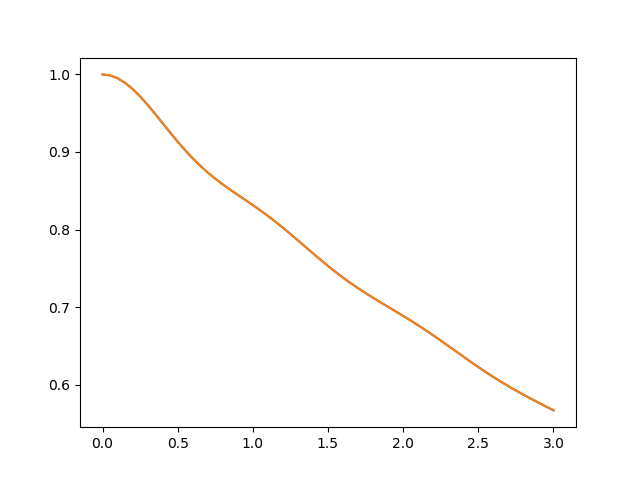

In [135]:
plt.plot(tlist,MxExp/MxExp[0])
plt.show()

In [9]:
dictpp=io.loadmat('M_z')

MxExp1=dictpp['M_z']

MxExp1=np.squeeze(MxExp1)

MxExp1.shape

(301,)

In [29]:
tlist=np.arange(0,Npts*delta*Nsteps,delta*Nsteps)

In [104]:
band[0]

array([ 0.41236814,  0.38302404,  0.21864426,  0.20016707,  0.19777439,
        0.19451877,  0.19039057,  0.18210842,  0.17934232,  0.16636322,
        0.16228521,  0.15138061,  0.14917268,  0.1410223 ,  0.13594834,
        0.12839962,  0.12592809,  0.11556592,  0.11470878,  0.11292953,
        0.10030647,  0.09876307,  0.09281018,  0.08664374,  0.08576328,
        0.08530768,  0.08486557,  0.0775136 ,  0.07503835,  0.07220578,
        0.06944519,  0.0682481 ,  0.06720691,  0.06696543,  0.06423648,
        0.06377336,  0.06252998,  0.06151354,  0.05911683,  0.05839557,
        0.0576111 ,  0.05516185,  0.05417428,  0.05386198,  0.05382685,
        0.05058423,  0.05048744,  0.04992994,  0.04893468,  0.04715249,
        0.04683014,  0.04566644,  0.04510022,  0.04451689,  0.0438733 ,
        0.04320397,  0.04296757,  0.0426628 ,  0.04032193,  0.03888403,
        0.03864613,  0.0380734 ,  0.0376338 ,  0.03653412,  0.0359084 ,
        0.03540813,  0.03494545,  0.03427284,  0.03350344,  0.03